In [5]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

In [6]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

# Q1 population growth

In [8]:
pip install -U pip setuptools wheel

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install --only-binary=:all: "tiktoken>=0.7.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 58.3 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install "jupyter-ai-magics[all]" -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
safety-schemas 0.0.14 requires pydantic<2.10.0,>=2.6.0, but you have pydantic 2.12.0 which is incompatible.
sparkmagic 0.21.0 requires pandas<2.0.0,>=0.17.1, but you have pandas 2.2.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [38]:
! pip install jupyter-ai-magics[all] -q

  error: subprocess-exited-with-error
  
  × Building wheel for tiktoken (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [50 lines of output]
      /tmp/pip-build-env-2odrykqj/overlay/lib/python3.10/site-packages/setuptools/config/_apply_pyprojecttoml.py:82: SetuptoolsDeprecationWarning: `project.license` as a TOML table is deprecated
      !!
      
              ********************************************************************************
              Please use a simple string containing a SPDX expression for `project.license`. You can also use `project.license-files`. (Both options available on setuptools>=77.0.0).
      
              By 2026-Feb-18, you need to update your project and remove deprecated calls
              or your builds will no longer be supported.
      
              See https://packaging.python.org/en/latest/guides/writing-pyproject-toml/#license for details.
              ******************************************************************

In [11]:
import warnings
warnings.simplefilter('ignore')

In [12]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

In [13]:
%load_ext jupyter_ai_magics

In [28]:
sql = """
     select * from oregon_population
     """

In [29]:
import pandas as pd

or_df = pd.read_sql(sql, con=conn)


In [30]:
%%ai gpt4
What is included in the {or_df}

The data includes the following columns:

- `year`: This column indicates the year in which the population count and year-on-year (yoy) percent growth were recorded. In this dataset, the years range from 2005 to 2019.

- `population`: This figure represents the population size of a specified area (not directly mentioned in the table) for each respective year. 

- `yoy_growth_pct`: This column represents the percentage growth rate of the population from the previous year to the current year. For example, in 2006, the population growth rate was 3.95 percent compared to 2005. The 'NaN' for 2005 implies that there's no available data to calculate a year-on-year growth percentage for that year, because we don't have the population data for 2004.

In [41]:
%%ai gpt4 -f code
Calculate the year on year growth rate with the data provided in {or_df} and visualize the result on a line chart with the growth rate

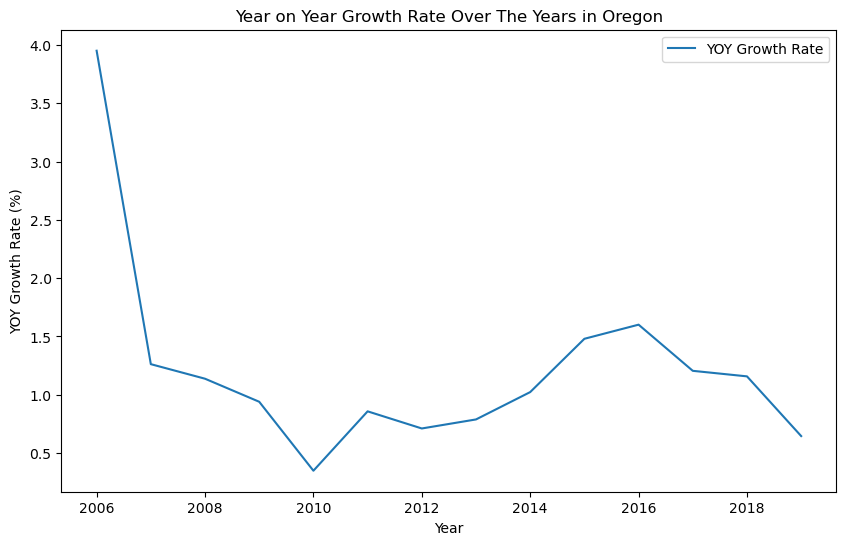

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'year': [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019],
    'population': [3560109, 3700758, 3747455, 3790060, 3825657, 3838957, 3871859, 3899353, 3930065, 3970239, 4028977, 4093465, 4142776, 4190713, 4217737]
})

df['yoy_growth_rate'] = df['population'].pct_change() * 100

plt.figure(figsize=(10,6))
plt.plot(df['year'], df['yoy_growth_rate'], label='YOY Growth Rate')
plt.title('Year on Year Growth Rate Over The Years in Oregon')
plt.xlabel('Year')
plt.ylabel('YOY Growth Rate (%)')
plt.legend(loc='best')
plt.show()

In [ ]:
I'm sorry but it's impossible to calculate the population growth rate with the provided data. The data only includes information on yearly income, but no details on population are provided. Please provide the population count for each corresponding year for the calculation.

The Year on Year income seems to have droped dramatically from 2006-2010 and hasn't fully reovered since then

# Question 2

In [72]:
sql_2 = """
     select * from oregon_income_population
     """

In [51]:
OR_df= pd.read_sql(sql_2, con=conn)
OR_df.head()

,name,year,income,pop
0,Oregon,2005,42944,3560109
1,Oregon,2006,46230,3700758
2,Oregon,2007,48730,3747455
3,Oregon,2008,50169,3790060
4,Oregon,2009,48457,3825657


In [53]:
%%ai gpt4 -f code
use the data in {OR_df}, create a dual axis chart where the x-axis=year, left y-axis= population(line), and the right Y-axis=median household income (bar or line, different color), and includes the state name in the title

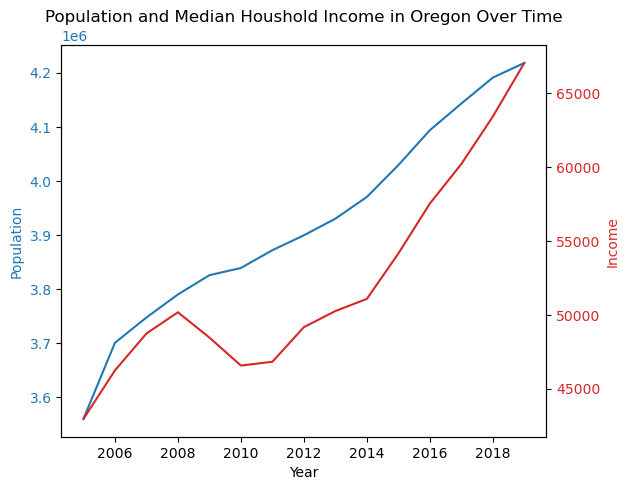

In [73]:
import matplotlib.pyplot as plt
import pandas as pd

# data
data = {'name': ['Oregon']*15, 'year': list(range(2005, 2020)), 
        'income': [42944, 46230, 48730, 50169, 48457, 46560, 46816, 49161, 50251, 51075, 54148, 57532, 60212, 63426, 67058], 
        'pop': [3560109, 3700758, 3747455, 3790060, 3825657, 3838957, 3871859, 3899353, 3930065, 3970239, 4028977, 4093465, 4142776, 4190713, 4217737]}

df = pd.DataFrame(data)

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Population', color=color)
ax1.plot(df['year'], df['pop'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Income', color=color)  
ax2.plot(df['year'], df['income'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.title("Population and Median Houshold Income in Oregon Over Time")
plt.show()

From the Charte above we can see thatin 2010 the income and population has a large disparity between the two

# Question 3

In [62]:
sql_3 = """
     select * from oregon_income_growth
     """

In [63]:
ORG_df= pd.read_sql(sql_3, con=conn)
ORG_df.head()

,year,income,annual_increase
0,2005,42944,NaN
1,2006,46230,3286.0
2,2007,48730,2500.0
3,2008,50169,1439.0
4,2009,48457,-1712.0


In [66]:
%%ai gpt4 -f code
Use the data in {ORG_df}, create a bar chart that shows the anual incrase of profit over time 

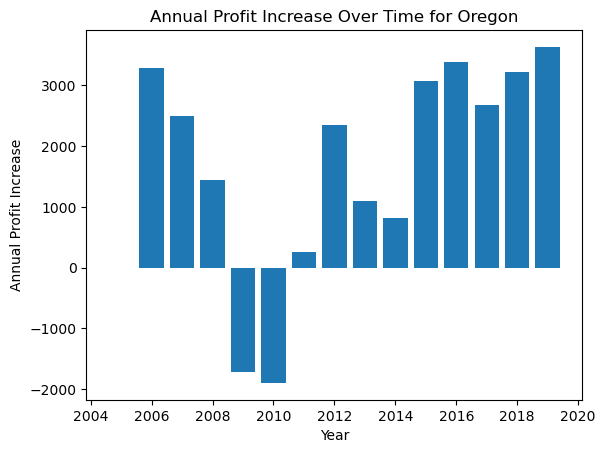

In [68]:
import matplotlib.pyplot as plt

# data
data = {
  'year': [2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019],
  'annual_increase': [0,3286.0,2500.0,1439.0,-1712.0,-1897.0,256.0,2345.0,1090.0,824.0,3073.0,3384.0,2680.0,3214.0,3632.0]
}

plt.bar(data['year'], data['annual_increase'])
plt.xlabel('Year')
plt.ylabel('Annual Profit Increase')
plt.title('Annual Profit Increase Over Time for Oregon')
plt.show()

After the year 2014 the income of Oregon increases and tends to stay relativly high in comparison to previous years